# 2. EDA e Pré-processamento - Tech Challenge Fase 3

Neste notebook, faremos a Análise Exploratória de Dados (EDA) para entender o comportamento dos atrasos e preparar os dados para os modelos de Machine Learning.

**Objetivos:**
1. Análise estatística descritiva.
2. Visualização de padrões de atraso (por companhia, aeroporto, sazonalidade).
3. Engenharia de Atributos (Feature Engineering).
4. Codificação (Encoding) e Escalonamento (Scaling).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1. Carga da Amostra Preparada

In [2]:
try:
    df = pd.read_csv('flights_prepared_sample.csv')
    print(f"Dataset carregado com sucesso! Shape: {df.shape}")
except FileNotFoundError:
    print("ERRO: Arquivo 'flights_prepared_sample.csv' não encontrado. Rode o notebook 1 primeiro.")

Dataset carregado com sucesso! Shape: (100000, 43)


## 2. Análise Estatística e Visualizações (EDA)

In [3]:
# Visão geral das variáveis numéricas relacionadas a tempo
cols_analise = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'AIR_TIME', 'DISTANCE']
display(df[cols_analise].describe())

,DEPARTURE_DELAY,ARRIVAL_DELAY,AIR_TIME,DISTANCE
count,100000.00,100000.00,100000.00,100000.00
mean,9.14,4.26,113.70,825.52
std,36.52,38.98,72.32,608.25
min,-44.00,-71.00,8.00,31.00
25%,-5.00,-13.00,60.00,372.00
50%,-2.00,-5.00,94.00,650.00
75%,7.00,8.00,144.00,1068.00
max,1670.00,1665.00,668.00,4983.00


### Pergunta 1: Quais companhias aéreas atrasam mais?
Vamos olhar a porcentagem de voos atrasados (`IS_DELAYED = 1`) por companhia.

/var/folders/6l/frb0wjw158j5k_dfkfzjzjm80000gn/T/ipykernel_3842/222493582.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=atraso_por_cia.values, y=atraso_por_cia.index, palette='viridis')


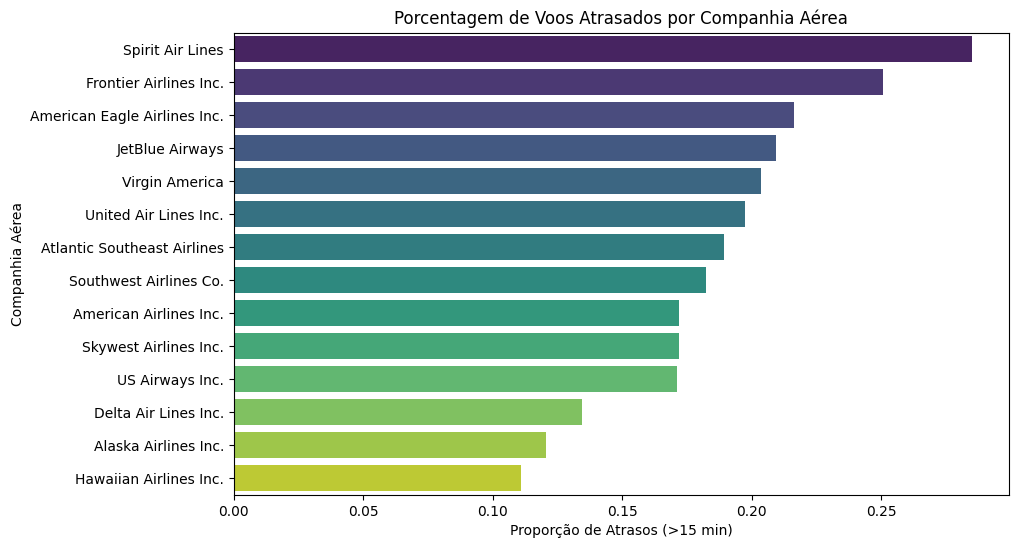

In [4]:
atraso_por_cia = df.groupby('AIRLINE_NAME')['IS_DELAYED'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=atraso_por_cia.values, y=atraso_por_cia.index, palette='viridis')
plt.title('Porcentagem de Voos Atrasados por Companhia Aérea')
plt.xlabel('Proporção de Atrasos (>15 min)')
plt.ylabel('Companhia Aérea')
plt.show()

### Pergunta 2: Sazonalidade (Dia da Semana e Mês)
Os atrasos são maiores em determinados dias ou meses?

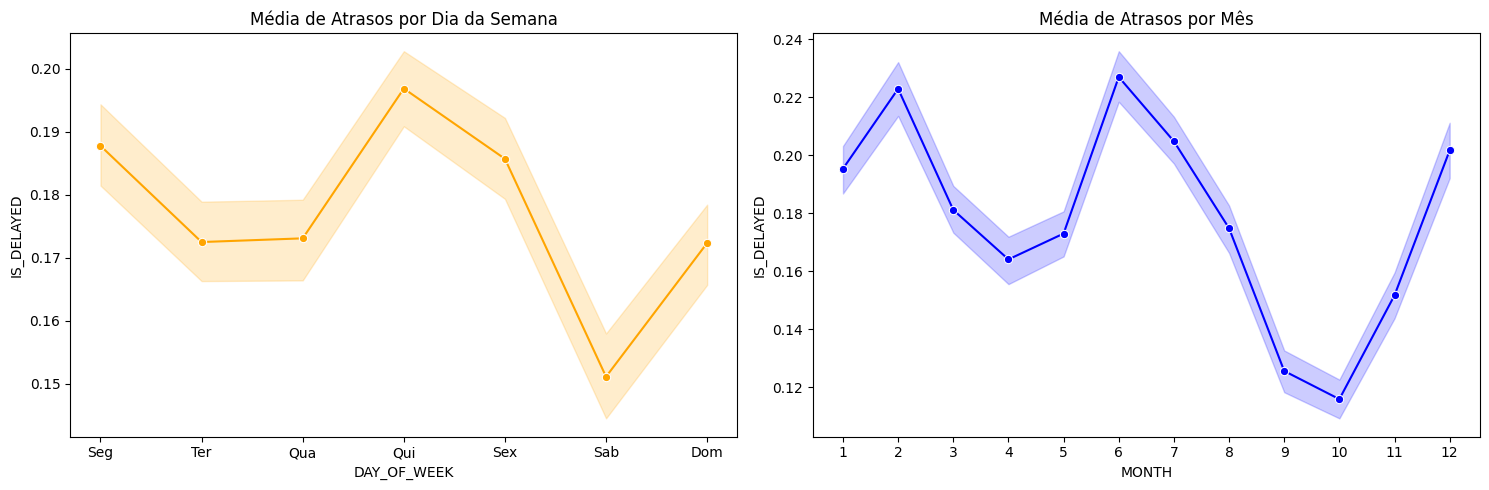

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Por Dia da Semana (1=Segunda, 7=Domingo)
sns.lineplot(data=df, x='DAY_OF_WEEK', y='IS_DELAYED', ax=ax[0], color='orange', marker='o')
ax[0].set_title('Média de Atrasos por Dia da Semana')
ax[0].set_xticks(range(1, 8))
ax[0].set_xticklabels(['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom'])

# Por Mês
sns.lineplot(data=df, x='MONTH', y='IS_DELAYED', ax=ax[1], color='blue', marker='o')
ax[1].set_title('Média de Atrasos por Mês')
ax[1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

### Pergunta 3: Correlações
Quais variáveis numéricas têm maior correlação com o atraso na chegada?

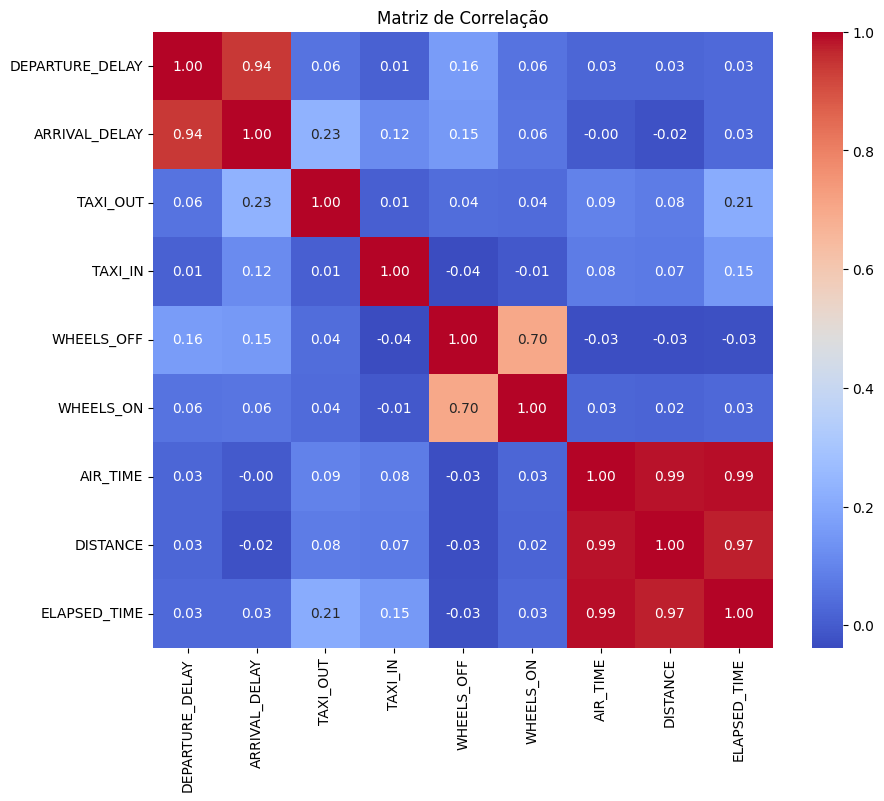

In [6]:
cols_corr = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'TAXI_OUT', 'TAXI_IN', 'WHEELS_OFF', 
             'WHEELS_ON', 'AIR_TIME', 'DISTANCE', 'ELAPSED_TIME']

plt.figure(figsize=(10, 8))
sns.heatmap(df[cols_corr].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

## 3. Pré-processamento para Machine Learning

Vamos preparar o dataset final (`X` e `y`).

**Etapas:**
1. **Remover colunas vazadoras (Data Leakage):** Colunas que "entregam" a resposta e não estarão disponíveis no momento da previsão futura (ex: `ARRIVAL_DELAY` exato, `DEPARTURE_DELAY` exato - depende do escopo, mas vamos assumir que queremos prever antes do voo sair ou baseado em dados programados).
    * *Nota:* Se o objetivo é prever atraso na CHEGADA dado que o voo já SAIU atrasado, podemos manter `DEPARTURE_DELAY`. Vamos assumir este cenário (cenário operacional).
2. **Encoding:** Transformar texto em número.
3. **Scaling:** Colocar variáveis na mesma escala.

In [7]:
# Seleção de Features Relevantes
features = [
    'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE_CODE', 
    'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DISTANCE', 
    'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 
    'DEPARTURE_DELAY' # Assumindo que sabemos o atraso da partida e queremos estimar a chegada
]

target_class = 'IS_DELAYED'
target_reg = 'ARRIVAL_DELAY'

# Filtrando dataset
df_model = df[features + [target_class, target_reg]].copy()

# Tratamento de Categóricas (Label Encoding para simplicidade em Árvores, OneHot para outros)
# Como temos MUITOS aeroportos, OneHot criaria milhares de colunas. Vamos usar LabelEncoder.
le = LabelEncoder()

cols_cat = ['AIRLINE_CODE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

for col in cols_cat:
    df_model[col] = df_model[col].astype(str) # Garantir string
    df_model[col] = le.fit_transform(df_model[col])

print("Visualizando dados codificados:")
display(df_model.head())

Visualizando dados codificados:


,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DEPARTURE_DELAY,IS_DELAYED,ARRIVAL_DELAY
0,7,27,1,9,345,465,318,1623,75.00,6.00,0,5.00
1,10,30,5,3,156,148,950,1823,165.00,1.00,0,-12.00
2,10,5,1,13,181,227,672,1150,115.00,8.00,0,5.00
3,11,17,2,3,287,531,214,1305,62.00,0.00,0,-3.00
4,9,11,5,9,388,538,224,600,60.00,-6.00,0,9.00


## 4. Escalonamento (Scaling)
Necessário para modelos baseados em distância (K-Means, KNN, SVM, Redes Neurais).

In [8]:
scaler = StandardScaler()
cols_num = ['DISTANCE', 'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DEPARTURE_DELAY']

df_model[cols_num] = scaler.fit_transform(df_model[cols_num])

print("Visualizando dados escalonados:")
display(df_model.head())

Visualizando dados escalonados:


,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DEPARTURE_DELAY,IS_DELAYED,ARRIVAL_DELAY
0,7,27,1,9,345,465,-0.83,0.61,-0.89,-0.09,0,5.00
1,10,30,5,3,156,148,0.20,1.02,0.30,-0.22,0,-12.00
2,10,5,1,13,181,227,-0.25,-0.37,-0.36,-0.03,0,5.00
3,11,17,2,3,287,531,-1.01,-0.05,-1.06,-0.25,0,-3.00
4,9,11,5,9,388,538,-0.99,-1.50,-1.09,-0.41,0,9.00


## 5. Exportação Final
Salvamos o dataset pronto para ser consumido pelos notebooks de Machine Learning (3 e 4).

In [9]:
df_model.to_csv('flights_ml_ready.csv', index=False)
print("Arquivo 'flights_ml_ready.csv' salvo com sucesso.")

Arquivo 'flights_ml_ready.csv' salvo com sucesso.
